# [DL] Project 2 - LSTM

Kacper Trębacz [145453]

Jan Gruszczyński [145464]

In the notebook Experiments.ipynb you can find our work leading to this solution.

### This notebook contains our final solution to the problem. 

In the notebook Experiments.ipynb we show our experimental work leading to this solution. 

Here we import specific libraries. As requested the model is implemented in tensorflow.

In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, Masking
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from attention import Attention
import random

### Data creation

In [4]:
np.random.seed(42)

In [5]:
n = 50000

In [6]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

We edited this part a bit, to have also an array of series lengths. 

In [7]:
xl, ll, yl = [], [], []
for _ in range(n):
    cl = (np.random.rand(5)<.25).astype(np.float32)
    row = createRow(np.random.randint(40,60), cl)
    ll.append([_,len(row)])
    xl.append(row)
    yl.append(cl)
    

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Here we apply padding to the series, in the result every series has the same length

In [9]:
X = keras.preprocessing.sequence.pad_sequences(
    xl, padding="post", dtype="float32"
)
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(yl, dtype=tf.float32)
lengths = tf.convert_to_tensor(ll, dtype=tf.int32)
X.shape, y.shape, lengths.shape

(TensorShape([50000, 59, 3]), TensorShape([50000, 5]), TensorShape([50000, 2]))

Division of data into training and validation shape.

In [10]:
X_train, y_train, X_valid, y_valid = X[:35000], y[:35000], X[35000:], y[35000:]
lengths_train, lengths_valid = lengths[:35000], lengths[35000:]

In [11]:
X_train.shape, y_train.shape, lengths_train.shape,

(TensorShape([35000, 59, 3]), TensorShape([35000, 5]), TensorShape([35000, 2]))

In [12]:
lengths_train[:,1]

<tf.Tensor: shape=(35000,), dtype=int32, numpy=array([58, 51, 59, ..., 59, 45, 43])>

Visualization of data

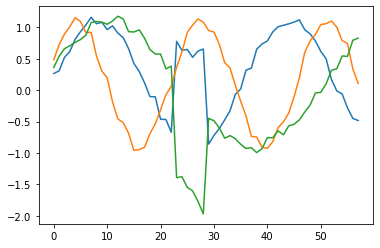

In [13]:
plt.plot(xl[0])

Please note: 

In the further part of the report, by for example anomaly of class 0 we mean anomaly described by 0-indexed element in the output vector describing the data point, etc.

### Part : 1 Classification of defects.

In this part we implement standard neural network using layers of LSTM's that will classify which type of defect we 
have encountered. 

This function implements Sliding Window Algorithm. For example from [b c d e f g h] it creates:
 [b c d]
 [c d e]
 [d e f]
 [e f g]
 [f g h]. 

Size of the sliding window is choosen according to series length.

In [52]:
def extract_patches(data, win_len=10):
    data = K.expand_dims(data, axis=3)
    patches = tf.image.extract_patches(data, sizes=[1, win_len, 1, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='VALID')
    patches = K.permute_dimensions(patches, (0, 1, 3, 2))
    return patches

Here we include structure of the smaller model which represents a part of the final model. As an input it takes the result of sliding window algorithm, and as a result it returns a vector of length 5 (number of classes). 

In [53]:
miniModel = Sequential()
miniModel.add(Input(shape=(10,3)))
miniModel.add(Dense(10))
miniModel.add(LSTM(64, return_sequences=True))
miniModel.add(LSTM(8))
miniModel.add(Dense(y_train.shape[1], 'sigmoid'))
miniModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 10)            40        
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 2336      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 21,621
Trainable params: 21,621
Non-trainable params: 0
_________________________________________________________________


This is the structure of the final model, as for the input it takes our 3 series of length 59. (The series were padded to max(lengths(series)). Then the series are inputed into the extract_patches function so that 50 series (x 3 for each series) are created of length 10 representing sliding windows. Every such sliding window is inputed into small model, described above, using TimeDistributed(), then the result is MaxPooled to return a result of length 5. (Vector representing  the predicted classes).

In [54]:
mainModel = Sequential()
mainModel.add(Input(shape=(59,3)))
mainModel.add(Lambda(extract_patches))
mainModel.add(TimeDistributed(miniModel))
mainModel.add(GlobalMaxPool1D())
mainModel.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy',tf.keras.metrics.Precision(thresholds=0.4, name="precision"),tf.keras.metrics.Recall(thresholds=0.4, name="recall"),tfa.metrics.F1Score(y_train.shape[1], threshold=0.4)])
mainModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 50, 10, 3)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 5)             21621     
_________________________________________________________________
global_max_pooling1d (Global (None, 5)                 0         
Total params: 21,621
Trainable params: 21,621
Non-trainable params: 0
_________________________________________________________________


Here we train our model: 

In [55]:
history = mainModel.fit(X_train, y_train, batch_size=512, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
69/69 [==============================] - 5s 78ms/step - loss: 0.6455 - binary_accuracy: 0.6251 - precision: 0.2546 - recall: 0.6893 - f1_score: 0.3633 - val_loss: 0.5770 - val_binary_accuracy: 0.7776 - val_precision: 0.2960 - val_recall: 0.2759 - val_f1_score: 0.1731
Epoch 2/30
69/69 [==============================] - 4s 61ms/step - loss: 0.5164 - binary_accuracy: 0.8065 - precision: 0.5929 - recall: 0.3200 - f1_score: 0.2810 - val_loss: 0.4704 - val_binary_accuracy: 0.8329 - val_precision: 0.8240 - val_recall: 0.3574 - val_f1_score: 0.3493
Epoch 3/30
69/69 [==============================] - 4s 61ms/step - loss: 0.4470 - binary_accuracy: 0.8371 - precision: 0.9294 - recall: 0.3669 - f1_score: 0.3757 - val_loss: 0.4275 - val_binary_accuracy: 0.8399 - val_precision: 0.9623 - val_recall: 0.3673 - val_f1_score: 0.3788
Epoch 4/30
69/69 [==============================] - 4s 61ms/step - loss: 0.4157 - binary_accuracy: 0.8415 - precision: 0.9848 - recall: 0.3737 - f1_score: 0.3833 -

As we can seen our model works almost perfectly. 

To predict our final classes, this modelExplain accept our three series of length 3, then for each sliding windows (50) it returns a vector of length 5 representing prediction of classes.

In [56]:
modelExplain = Model(inputs=mainModel.layers[0].input, outputs=mainModel.layers[-2].output)
modelExplain.summary()

Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 59, 3)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 50, 10, 3)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 5)             21621     
Total params: 21,621
Trainable params: 21,621
Non-trainable params: 0
_________________________________________________________________


Here we present detailed result for one prediction.

tf.Tensor([0. 1. 1. 0. 0.], shape=(5,), dtype=float32)


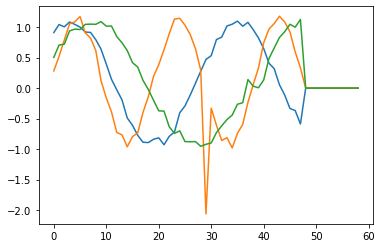

In [57]:
# Correct label and visualization.
i = 9
print(y_valid[i])
plt.plot(X_valid[i])
plt.show()

In [74]:
output = modelExplain.predict(X_valid[i:i+1])[0]
output.shape

(50, 5)

As we can see, the model correctly found two anomalies. They were located in the two sliding windows (begining with index 29 and 37).

Please note, that up to this point we know what type of anomaly classes and where they occure, but we don't know on which series they do occure.

In [59]:
clses = np.max(output, axis=0)
print(clses)
y_pred = clses > 0.4
print(y_pred)
for cls in np.where(y_pred)[0]:
    start = np.argmax(output[:,cls])
    # Sliding window ranges containing anomalies.
    print(start,start+10)

[0.0257405  0.9580926  0.9400406  0.01134131 0.01116045]
[False  True  True False False]
28 38
37 47


Here we present Roc Curves for each classes predicted by the model.

In [75]:
p_valid = mainModel.predict(X_valid)

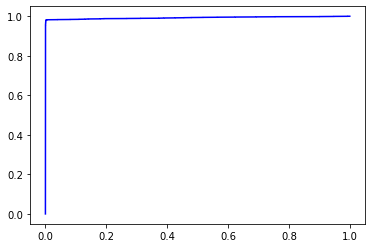

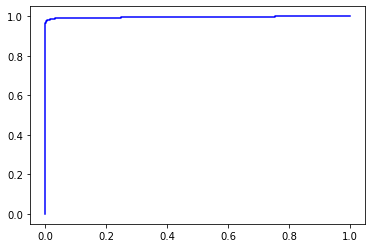

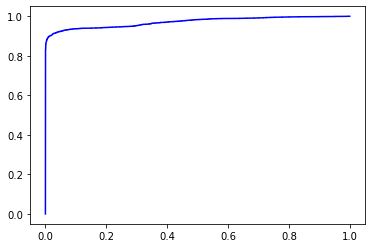

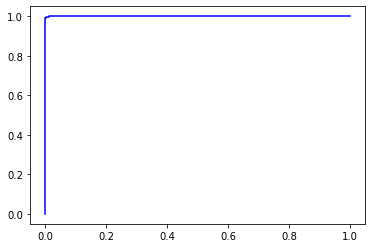

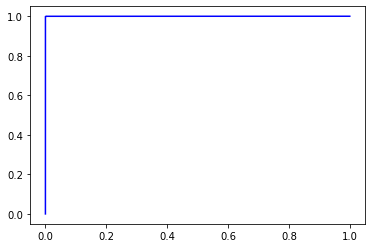

In [61]:
# Classes 0 to 4.
for i in range(0, 5):
    fpr, tpr, threshold = roc_curve(y_valid.numpy()[:,i],p_valid[:,i])
    plt.plot(fpr, tpr, 'b')
    plt.show()

### Part 2: Finding on which series and where on it the anomaly occured. 

#### Side note

We tried using attention to detect where anomaly is located, as the raise of the alpha coefficient peaked right after encountering the anomaly, but unfortuantely this approach failed when there where two anomalies from different classes on the same signal. 

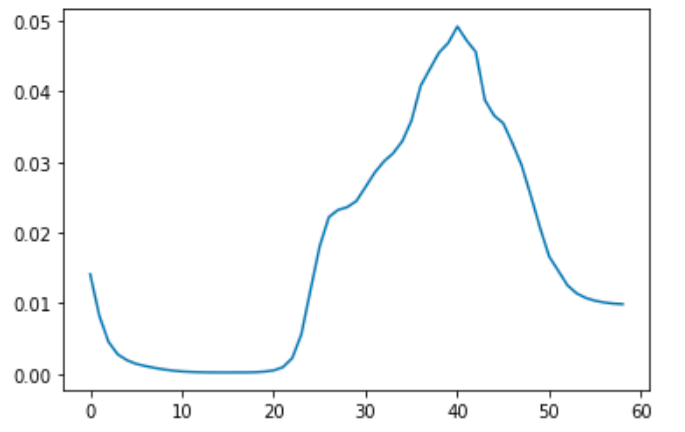

Above we present the obtained chart of alpha coefficient mentioned above.

#### End of side note


As we tackled the classification problem succesfully, we now wanted to find which class correspond to which series.

To do that we tested all combinations of models to find which one infact can predict succefully individual classes.

In [62]:
# This function tests singiel model.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=6, min_delta = 0.0001, restore_best_weights=True, mode="max")
def train_model(cls, signals, win_len=10):
    X_train_l, y_train_l = tf.gather(X_train, signals, axis=2), tf.gather(y_train, cls, axis=1)
    X_valid_l, y_valid_l = tf.gather(X_valid, signals, axis=2), tf.gather(y_valid, cls, axis=1)
    miniModel = Sequential()
    miniModel.add(Input(shape=(10,len(signals))))
    miniModel.add(Dense(10))
    miniModel.add(LSTM(64, return_sequences=True))
    miniModel.add(LSTM(8))
    miniModel.add(Dense(1, 'sigmoid'))
    
    mainModel = Sequential()
    mainModel.add(Input(shape=(59,len(signals))))
    mainModel.add(Lambda(extract_patches))
    mainModel.add(TimeDistributed(miniModel))
    mainModel.add(GlobalMaxPool1D())
    mainModel.compile('adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.Precision(thresholds=0.4, name="precision"),tf.keras.metrics.Recall(thresholds=0.4, name="recall"),tfa.metrics.F1Score(1, threshold=0.4)])
    
    history = mainModel.fit(X_train_l, y_train_l, batch_size=512, epochs=30, validation_data=(X_valid_l, y_valid_l), callbacks=[early_stopping])
    precision = history.history["val_precision"][-1]
    recall = history.history["val_recall"][-1]
    return (cls,signals, mainModel, precision, recall)

So for example for class 0, we check  if prediction based only on series number one would allow us to predict the class 0, then we check if prediction based just on second series would allow us to predict the class 0, and then we check if prediction based just on third series would allow us to predict the class 0. Finally we find that we can predict class 0 based on series number 3. Now we now that anomaly described by class one happens on third series. We perform this action for each class.

In [63]:
all_models = []
# We have 5 classes
for cls in range(0,5):
    # Our input is of 3 series length
    for size in range(1,4):
        # One anomaly class can be connected up to 2 signals. 
        for comb in combinations([0,1,2], size):
            # we do not train model based on set of signals if models trained on some of individual from this set couldn not learn
            if all([(prec >= 0.5 and rec >= 0.5) for cls2,signals,model,prec,rec in all_models if cls2 == cls and len(signals) == 1 and signals[0] in comb]):
                print("################################")
                print(cls,comb)
                print("##################################")
                result = train_model(cls, comb)
                all_models.append(result)

################################
0 (0,)
##################################
Epoch 1/30
69/69 [==============================] - 5s 78ms/step - loss: 0.6048 - acc: 0.7248 - precision: 0.2591 - recall: 0.3998 - f1_score: 0.3144 - val_loss: 0.5598 - val_acc: 0.7526 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/30
69/69 [==============================] - 4s 58ms/step - loss: 0.5522 - acc: 0.7463 - precision: 0.4684 - recall: 0.0542 - f1_score: 0.0972 - val_loss: 0.4467 - val_acc: 0.7752 - val_precision: 0.5502 - val_recall: 0.6249 - val_f1_score: 0.5852
Epoch 3/30
69/69 [==============================] - 4s 58ms/step - loss: 0.2774 - acc: 0.8787 - precision: 0.7064 - recall: 0.8950 - f1_score: 0.7896 - val_loss: 0.2430 - val_acc: 0.8915 - val_precision: 0.6964 - val_recall: 0.9709 - val_f1_score: 0.8110
Epoch 4/30
69/69 [==============================] - 4s 58ms/step - loss: 0.1488 - acc: 0.9526 - precision: 0.8700 - recall: 0.9424 - f1_score: 0.904

69/69 [==============================] - 4s 58ms/step - loss: 0.0388 - acc: 0.9895 - precision: 0.9988 - recall: 0.9615 - f1_score: 0.9798 - val_loss: 0.0361 - val_acc: 0.9882 - val_precision: 0.9997 - val_recall: 0.9601 - val_f1_score: 0.9795
Epoch 9/30
69/69 [==============================] - 4s 59ms/step - loss: 0.0254 - acc: 0.9926 - precision: 0.9995 - recall: 0.9740 - f1_score: 0.9866 - val_loss: 0.0223 - val_acc: 0.9943 - val_precision: 1.0000 - val_recall: 0.9823 - val_f1_score: 0.9911
Epoch 10/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0159 - acc: 0.9961 - precision: 1.0000 - recall: 0.9864 - f1_score: 0.9931 - val_loss: 0.0227 - val_acc: 0.9979 - val_precision: 0.9997 - val_recall: 0.9928 - val_f1_score: 0.9962
Epoch 11/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0124 - acc: 0.9974 - precision: 0.9997 - recall: 0.9909 - f1_score: 0.9952 - val_loss: 0.0110 - val_acc: 0.9979 - val_precision: 1.0000 - val_recall: 0.9922 - val_f1_sco

Epoch 3/30
69/69 [==============================] - 4s 58ms/step - loss: 0.5637 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/30
69/69 [==============================] - 4s 59ms/step - loss: 0.5638 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 5/30
69/69 [==============================] - 4s 58ms/step - loss: 0.5637 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 6/30
69/69 [==============================] - 4s 58ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 -

Epoch 21/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0056 - acc: 0.9999 - precision: 0.9999 - recall: 0.9998 - f1_score: 0.9998 - val_loss: 0.0049 - val_acc: 0.9998 - val_precision: 0.9990 - val_recall: 1.0000 - val_f1_score: 0.9995
Epoch 22/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0044 - acc: 0.9999 - precision: 0.9995 - recall: 1.0000 - f1_score: 0.9998 - val_loss: 0.0035 - val_acc: 0.9999 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 23/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0029 - acc: 1.0000 - precision: 0.9998 - recall: 1.0000 - f1_score: 0.9999 - val_loss: 0.0019 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
################################
3 (2,)
##################################
Epoch 1/30
69/69 [==============================] - 5s 76ms/step - loss: 0.5956 - acc: 0.7322 - precision: 0.2555 - recall: 0.2960 - f1_score: 0.2742 - val_l

Epoch 21/30
69/69 [==============================] - 4s 58ms/step - loss: 7.7395e-04 - acc: 1.0000 - precision: 1.0000 - recall: 0.9999 - f1_score: 0.9999 - val_loss: 7.4921e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 22/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0015 - acc: 0.9997 - precision: 0.9997 - recall: 0.9995 - f1_score: 0.9996 - val_loss: 8.5581e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
################################
4 (1,)
##################################
Epoch 1/30
69/69 [==============================] - 5s 76ms/step - loss: 0.5989 - acc: 0.7241 - precision: 0.2598 - recall: 0.3305 - f1_score: 0.2909 - val_loss: 0.5581 - val_acc: 0.7540 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/30
69/69 [==============================] - 4s 58ms/step - loss: 0.5658 - acc: 0.7471 - precision: 0.0000e+00 - recall: 0.0000

Epoch 23/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0157 - acc: 0.9971 - precision: 0.9980 - recall: 0.9906 - f1_score: 0.9943 - val_loss: 0.0148 - val_acc: 0.9975 - val_precision: 0.9984 - val_recall: 0.9902 - val_f1_score: 0.9943
Epoch 24/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0153 - acc: 0.9970 - precision: 0.9967 - recall: 0.9915 - f1_score: 0.9941 - val_loss: 0.0148 - val_acc: 0.9974 - val_precision: 0.9954 - val_recall: 0.9927 - val_f1_score: 0.9940
Epoch 25/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0144 - acc: 0.9975 - precision: 0.9975 - recall: 0.9918 - f1_score: 0.9946 - val_loss: 0.0136 - val_acc: 0.9977 - val_precision: 0.9992 - val_recall: 0.9913 - val_f1_score: 0.9952
Epoch 26/30
69/69 [==============================] - 4s 58ms/step - loss: 0.0139 - acc: 0.9975 - precision: 0.9984 - recall: 0.9921 - f1_score: 0.9952 - val_loss: 0.0138 - val_acc: 0.9973 - val_precision: 0.9997 - val_recall: 0.9905

In [64]:
for res in all_models:
    print(res)

(0, (0,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002007867E288>, 0.9994603395462036, 0.9981136918067932)
(0, (1,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000020087B9F6C8>, 0.0, 0.0)
(0, (2,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200969E3988>, 0.0, 0.0)
(1, (0,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200A5061D48>, 0.0, 0.0)
(1, (1,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200B3B93208>, 1.0, 0.9965184926986694)
(1, (2,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200C19DA7C8>, 0.0, 0.0)
(2, (0,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200B5CFCE08>, 0.0, 0.0)
(2, (1,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200DF63FE88>, 0.0, 0.0)
(2, (2,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200EE442D48>, 0.9904450178146362, 

Here we filter models that are infact capable of prediction. We do that by 
skipping models that have precission and recall lower than 0.5. 
Also if one model predicts anomaly based on more than one series for example series (0, 2), it can be admitted into the list of filtered models only and only if models predicting the anomaly based on a singiel series (0, 2) also were able to predicted the anomaly, otherwise the model is ignored.

In [65]:
filtered = []
for cls,signals,model,prec,rec in all_models:
    if prec <= 0.5 or rec <= 0.5:
        continue
    if len(signals) > 1:
        if any(res[3] <= 0.5 or res[4] <= 0.5 for res in all_models if res[0] == cls and len(res[1])==1 and res[1][0] in signals):
            continue
    filtered.append((cls,signals,model,prec,rec))
for f in filtered:
    print(f)

(0, (0,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002007867E288>, 0.9994603395462036, 0.9981136918067932)
(1, (1,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200B3B93208>, 1.0, 0.9965184926986694)
(2, (2,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000200EE442D48>, 0.9904450178146362, 0.967208743095398)
(3, (1,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000020108A6EE48>, 1.0, 1.0)
(4, (0,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002012643C408>, 1.0, 1.0)
(4, (2,), <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000020144282D08>, 1.0, 0.9910569190979004)
(4, (0, 2), <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002015374DA08>, 0.9997290968894958, 1.0)


Here we save our models to disk, so the experiment can be easily reproduced.

In [66]:
for cls,signals,model,prec,rec in filtered:
    model_json = model.to_json()
    with open(f"models2/model_{cls}_{signals}.json", "w+", encoding='utf-8') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"models2/model_{cls}_{signals}.h5")
    print("Saved model to disk")
    

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


Here we load our saved models from the disk.

In [14]:
good_models = []
for path in [p for p in Path("models2").iterdir() if p.suffix == ".json"]:
    with open(path, 'r', encoding='utf-8') as out_file:
        loaded_json_model = json.load(out_file, encoding='utf-8')
    loaded_model = model_from_json(json.dumps(loaded_json_model))
    
#     json_file = open(str(path), 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
    
    # load weights into new model
    loaded_model.load_weights(f"models2/{path.stem}.h5")
    loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc',tf.keras.metrics.Precision(thresholds=0.4),tf.keras.metrics.Recall(thresholds=0.4),tfa.metrics.F1Score(1, threshold=0.4)])
    print("Loaded model from disk")
    splitted = path.stem.split("_")
    cls = int(splitted[1])
    signals = [int(num) for num in splitted[2][1:-1].split(",") if num]
    print(cls,signals)
    good_models.append((cls,signals,loaded_model))
 

Loaded model from disk
0 [0]
Loaded model from disk
1 [1]
Loaded model from disk
2 [2]
Loaded model from disk
3 [1]
Loaded model from disk
4 [0, 2]
Loaded model from disk
4 [0]
Loaded model from disk
4 [2]


Now that we know which anomaly corresponds to which series, we just need to find out where exactly the anomaly happens.

### Part 2.5: Find the location of anomaly

Now that we have gathered smallest subset of models predicting classes of anomalies, and to every series we assigned a  model that predicts where the anomaly is we can predict where the anomaly is located. Yo find where the anomaly of certain class is located, we just need to use assigned model/models to the class. The models, as described above,return probability of occurence of each anomaly class in 50 slide windows. We pick such windows that have the highest probability of anomaly occurence.

In [16]:
class SubModel():
    def __init__(self, cls,signals,model,submodels = []):
        self.cls = cls
        self.signals = signals
        self.model = model
        self.submodels = {}
        for cs,sg,model in submodels:
            self.submodels[tuple(sg)] = model
        
    def predict(self,X):
        return self.model.predict(tf.gather(X, self.signals, axis=2))
    
    def explain(self,X):
        to_predict = []
        if len(self.submodels) > 0:
            for signals, model in self.submodels.items():
                to_predict.append((signals,model))
        else:
            to_predict.append((self.signals, self.model))
            
        for signals, model in to_predict:
            modelExplain = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
            cur_X = tf.gather(X, signals, axis=2)
            prediction = modelExplain.predict(cur_X)[0]
            if np.max(prediction) >= 0.4:
                print(f"Class: {self.cls} Signal: {signals}")
                where = np.where(prediction >=0.4)[0]
#                 print(where)
                win_len = 10
                for start in where:
#                     print(start)
                    plt.axvspan(start,start+10,color='red', alpha=prediction[start][0]*0.1)
                plt.plot(cur_X[0])
                plt.show()

In [17]:
class SuperModel():
    def __init__(self, model_candidates):
        self.models = [0]*5
        for cls in range(5):
            models_for_class = [mc for mc in model_candidates if mc[0] == cls]
            if len(models_for_class) > 1:
                srt_models = sorted(models_for_class,key = lambda m: len(m[1]), reverse = True)
                _,signals, biggest = srt_models[0]
                self.models[cls] = SubModel(cls,signals,biggest,srt_models[1:])
                
            else:
                _,signals,model = models_for_class[0]
                self.models[cls] = SubModel(cls,signals,model)
                
    def predict(self,X):
        result = np.zeros((X.shape[0],5))
        for i in range(5):
            model = self.models[i]
            result[:,i] = model.predict(X)[:,0]
        return result
    
    def explain(self,X):#important just one example
        assert X.shape[0] == 1
        plt.plot(X[0])
        plt.show()
        for cls in range(5):
            model = self.models[cls]
            model.explain(X)

In [18]:
sm = SuperModel(good_models)

Here we show how the proposed solution works:

Intensity of the color represents the confidence of the model.

Valid:  tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


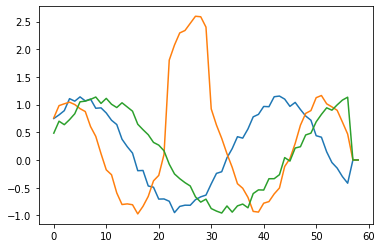

Class: 3 Signal: [1]


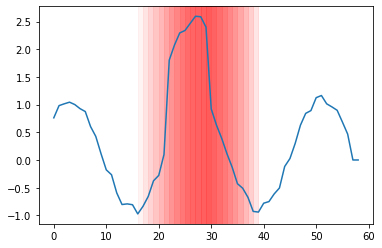

In [19]:
which = 3
print("Valid: ", y_valid[which])
sm.explain(X_valid[which:which+1])

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


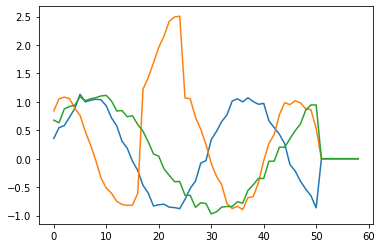

Class: 3 Signal: [1]


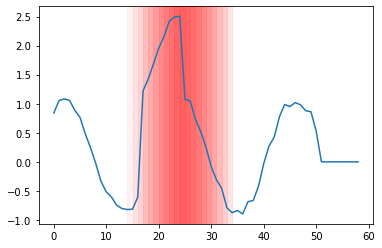

In [20]:
which = 8
print(y_valid[which])
sm.explain(X_valid[which:which+1])

tf.Tensor([1. 0. 0. 1. 1.], shape=(5,), dtype=float32)


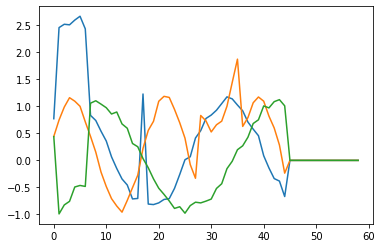

Class: 0 Signal: [0]


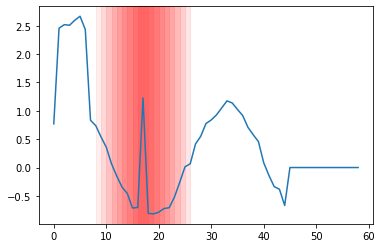

Class: 3 Signal: [1]


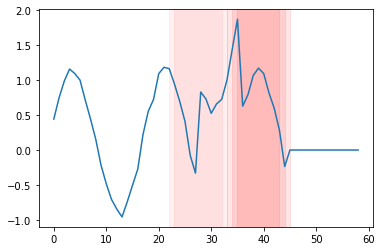

Class: 4 Signal: (0,)


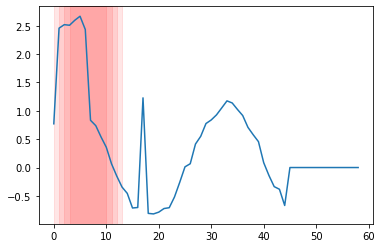

Class: 4 Signal: (2,)


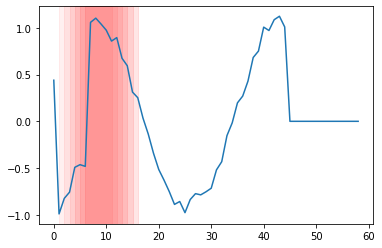

In [21]:
#Here for example, the model made small mistake predicting the location of anomaly corresponding to class 3.
which = 237
print(y_valid[which])
sm.explain(X_valid[which:which+1])

### Sources
https://stackoverflow.com/questions/50980113/evaluate-a-function-in-a-sliding-window-with-keras

Thank you for reading our report. 